# CWT & STFT + CNN Model with BCI_competitionIII dataset

In [1]:
import mne
import numpy as np
from mne.datasets import eegbci
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage

raw_each = [0] * 5

for i in range(0,5):
    raw_each[i] = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\hand"+ str(i) +"_new.edf",preload = True)

# raw_edf = mne.concatenate_raws(raw_each)
raw_edf = mne.concatenate_raws([raw_each[3]])
# raw_edf = raw_edf.copy().resample(62.5 ,npad="auto")

eegbci.standardize(raw_edf)  # set channel names
montage = make_standard_montage("standard_1005")
raw_edf.set_montage(montage)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand0_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand1_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand2_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand3_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand4_n

<RawEDF | hand3_new.edf, 8 x 279250 (1117.0 s), ~17.1 MB, data loaded>

In [2]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Activation
from keras.models import Sequential
from keras.callbacks import History,ModelCheckpoint
history = History()
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mne.decoding import CSP
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit,StratifiedKFold ,cross_val_score, cross_val_predict
from ssqueezepy import ssq_cwt, ssq_stft

In [3]:
eeg1 = raw_edf.copy().filter(l_freq=1.0, h_freq=30.0, method = 'iir', iir_params= {"order": 5, "ftype":'butter'})
# eeg1 = raw_edf.copy().filter(l_freq=0.075, h_freq=3.0, method = 'fir')
eeg1 = eeg1.copy().set_eeg_reference(ref_channels="average")

eeg1= eeg1.pick(["Fz","C3", "Cz", "C4","Pz",'PO7','PO8'])
# eeg1= eeg1.pick_channels(["C3", "Cz", "C4"])
events, event_dict = mne.events_from_annotations(eeg1)
combine_epochs = mne.Epochs(eeg1, events, 
        tmin=-5.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=5.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop'
    )

combine_epochs = combine_epochs.copy().crop(tmin=0.0, tmax=2.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Incorrect', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_Train']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
605 matching events found
Setting baseline interval to [-5.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 605 events and 2501 original time points ...
2 bad epochs dropped


In [4]:
combine_epochs

Number of events,603
Events,OVTK_GDF_Cross_On_Screen: 1OVTK_GDF_End_Of_Session: 1OVTK_GDF_End_Of_Trial: 120OVTK_GDF_Feedback_Continuous: 120OVTK_GDF_Left: 30OVTK_GDF_Right: 30OVTK_GDF_Start_Of_Trial: 120OVTK_GDF_Tongue: 30OVTK_GDF_Up: 30OVTK_StimulationId_BaselineStart: 0OVTK_StimulationId_BaselineStop: 1OVTK_StimulationId_Beep: 120OVTK_StimulationId_Train: 0
Time range,0.000 – 2.000 s
Baseline,-5.000 – 0.000 s


In [20]:
# Prepare Labels and Train data
combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data().shape[2]
labels = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].events[:,2]
for i in range(0,len(labels)):
    if labels[i] > 7:
        labels[i] = labels[i] - 1

shape = np.shape(combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data())
train_data = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data()

In [6]:
np.shape(train_data)

(120, 7, 501)

Train with CSP+LDA

In [7]:
from mne.decoding import CSP
lda = LinearDiscriminantAnalysis()
from sklearn.metrics import confusion_matrix
csp2 = CSP(n_components=7, reg=None, log=None, norm_trace=False)
clf = Pipeline([("CSP", csp2), ("LDA", lda)])
scores = cross_val_score(clf, train_data, labels, cv=10, n_jobs=None)
CSP_predicted = cross_val_predict(clf, train_data, labels, cv=10)

conf_matrix = confusion_matrix(labels, CSP_predicted)
print(conf_matrix)
print('Accuracy',np.mean(scores))

Computing rank from data with rank=None
    Using tolerance 1.3 (2.2e-16 eps * 7 dim * 8.2e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3 (2.2e-16 eps * 7 dim * 8.6e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3 (2.2e-16 eps * 7 dim * 8e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4 (2.2e-16 eps * 7 dim * 9e+14  max singular value)
    Estimated rank (mag): 7
    MAG: ra

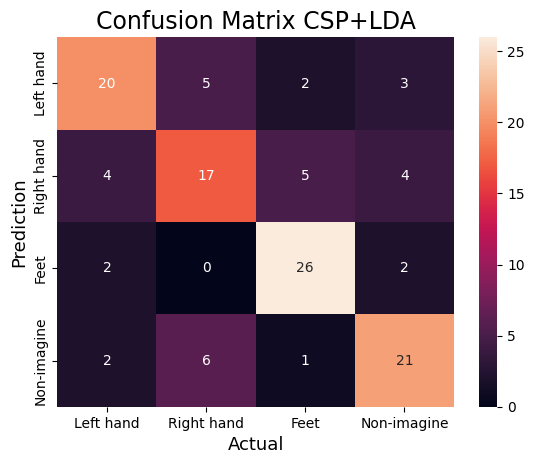

In [8]:
import seaborn as sns
class_names = ['Left hand', 'Right hand', 'Feet', 'Non-imagine']

sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix CSP+LDA',fontsize=17)
plt.show()

# CSP -> CWT -> CNN

In [9]:
csp = CSP(n_components=7, reg=None, log=None, norm_trace=False, transform_into='csp_space')
csp.fit(train_data, labels)
new_data = csp.transform(train_data)

Computing rank from data with rank=None
    Using tolerance 1.3 (2.2e-16 eps * 7 dim * 8.6e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4 (2.2e-16 eps * 7 dim * 9e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3 (2.2e-16 eps * 7 dim * 8.5e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 7 dim * 9.5e+14  max singular value)
    Estimated rank (mag): 7
    MAG: 

STFT

In [10]:
# from ssqueezepy import ssq_cwt, ssq_stft

# n_fft = 256  # Number of DFT points
# hop_length = int(n_fft * 0.03)  # 97% overlapping
# win_length = int(n_fft * 0.5)   # 0.5 seconds window length
# window = 'hamming' 
# train_size = len(labels)
# train_data_stft = np.ndarray(shape=(train_size, 129,143,7))


# _,coeff, *_ = ssq_stft(new_data[0,:], n_fft=n_fft, hop_len=hop_length, win_len=win_length, window=window)
# for i in range(0,train_size):
#     _,coeff, *_ = ssq_stft(new_data[0,:], n_fft=n_fft, hop_len=hop_length, win_len=win_length, window=window)
#     train_data_stft[i, :, :, :] = abs(coeff.reshape(coeff.shape[1],coeff.shape[2],coeff.shape[0]))

# np.shape(train_data_stft)

In [11]:
np.shape(new_data)

(120, 7, 501)

CWT

In [12]:
train_cwt = np.ndarray(shape=(new_data.shape[0], new_data.shape[2], 7))
for jj in range(0, new_data.shape[0]):
    train_cwt[jj] = new_data[jj].T
print(np.shape(new_data))

scales = range(1,31)

waveletname = 'morl'
train_size = len(labels)
train_data_cwt = np.ndarray(shape=(train_size, len(scales), new_data.shape[2], 7))

for ii in range(0,train_size):
    if ii % 40 == 0:
        print(ii)
    for jj in range(0,7):
        signal = train_cwt[ii, :, jj]
        coeff, _ = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:new_data.shape[2]]  #crop 227 sample for each channel
        train_data_cwt[ii, :, :, jj] = np.abs(coeff_)
print(np.shape(train_data_cwt))

(120, 7, 501)
0
40
80
(120, 30, 501, 7)


In [13]:
# Stack array and convert to image
# from PIL import Image as im 
# train_cwt_stack = np.ndarray(shape=(train_size, len(scales)*7, new_data.shape[2], 3))

# for jj in range(0,train_data_cwt.shape[0]):
#     # train_cwt_stack[jj] = np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2], train_data_cwt[jj,:,:,3], train_data_cwt[jj,:,:,4], train_data_cwt[jj,:,:,5], train_data_cwt[jj,:,:,6]))
#     train_cwt_stack[jj] = im.fromarray(np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2], train_data_cwt[jj,:,:,3], train_data_cwt[jj,:,:,4], train_data_cwt[jj,:,:,5], train_data_cwt[jj,:,:,6])), 'RGB')

# print(np.shape(train_cwt_stack))

(120, 210, 501, 3)


In [14]:
x_train, x_test, y_train, y_test = train_test_split(train_data_cwt, labels, test_size=0.3, random_state=42)

img_x = train_data_cwt.shape[1]
img_y = train_data_cwt.shape[2]
img_z = train_data_cwt.shape[3]
num_classes = 4

batch_size = 16
epochs = 100
print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))

# plt.imshow(x_train[0,:,:,1], aspect='auto', cmap='turbo')
# plt.show()
y_train = keras.utils.to_categorical(y_train - 6, num_classes)
y_test = keras.utils.to_categorical(y_test -6 , num_classes)
input_shape = (img_x, img_y, img_z)

(84, 30, 501, 7) (36, 30, 501, 7) (84,) (36,)


# Purposed CNN Model

In [15]:
# Define the CNN model
model = Sequential()

# Convolutional Layer 1 with 32 filters of kernel size 3x3
model.add(Conv2D(32, (3, 3), input_shape=(train_data_cwt.shape[1], train_data_cwt.shape[2], 7), activation='relu'))

# Max-Pooling Layer 1 with pool size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2 with 64 filters of kernel size 3x3
model.add(Conv2D(64, (3, 3), activation='relu'))

# Max-Pooling Layer 2 with pool size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the previous layer
model.add(Flatten())

# Output Layer with the desired number of output nodes (adjust as needed)
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(learning_rate= 0.0001), 
              metrics=['accuracy'])

model.summary()

# checkpoint = ModelCheckpoint("CNN_model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.fit(x_train, y_train, batch_size=batch_size, 
          epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[history])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 499, 32)       2048      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 249, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 247, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 123, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 47232)             0         
                                                                 
 dense (Dense)               (None, 4)                 1

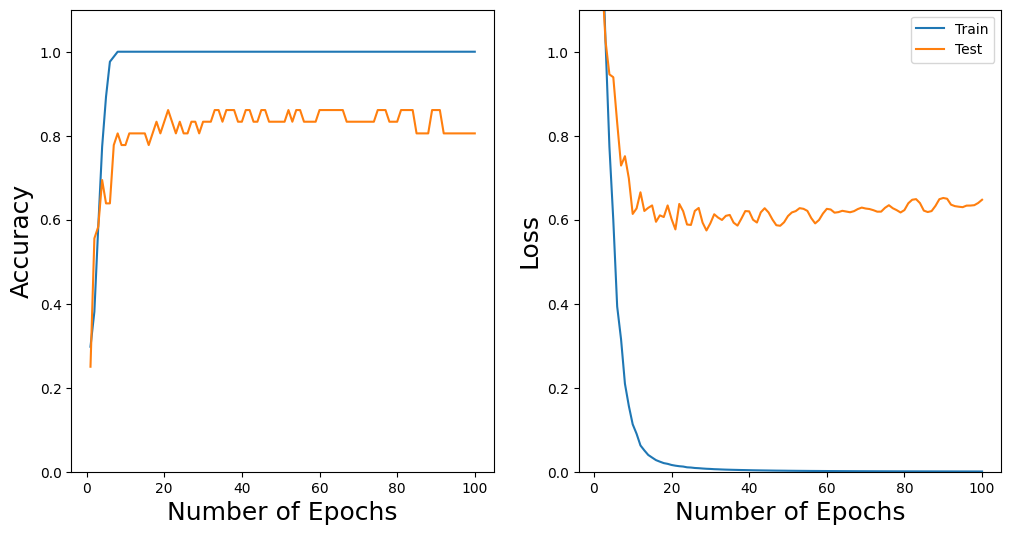

In [16]:
fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
axarr[0].plot(range(1, epochs+1), history.history['accuracy'], label='Train')
axarr[0].plot(range(1, epochs+1), history.history['val_accuracy'], label='Test')
axarr[0].set_xlabel('Number of Epochs', fontsize=18)
axarr[0].set_ylabel('Accuracy', fontsize=18)
axarr[0].set_ylim([0,1.1])
axarr[1].plot(range(1, epochs+1), history.history['loss'], label='Train')
axarr[1].plot(range(1, epochs+1), history.history['val_loss'], label='Test')
axarr[1].set_xlabel('Number of Epochs', fontsize=18)
axarr[1].set_ylabel('Loss', fontsize=18)
axarr[1].set_ylim([0,1.1])
plt.legend()
plt.show()

In [17]:
# from keras.models import load_model
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# pretrained_model = load_model("2D_CNN_model_weights.h5")

# loss, accuracy = pretrained_model.evaluate(x_test, y_test)

# y_pred = pretrained_model.predict(x_test)
# y_pred = np.argmax(y_pred, axis=1) 
# y_true = np.argmax(y_test, axis=1)

# confusion_mat = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

# CNN Model (From Paper)

In [18]:
# # Define the CNN model
# model = Sequential()

# # Convolutional Layer with 16 filters of kernel size 3 and ReLU activation
# model.add(Conv2D(16, (3, 3), input_shape=input_shape))
# model.add(Activation('relu'))

# # Max-Pooling Layer with pool size 2x2 and stride 2
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# # Flatten the output from the previous layer
# model.add(Flatten())

# # Output Layer with 4 nodes
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss=keras.losses.categorical_crossentropy, 
#               optimizer=keras.optimizers.Adam(learning_rate= 0.0001), 
#               metrics=['accuracy'])

# model.summary()

# checkpoint = ModelCheckpoint("3D_CNN_model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# model.fit(x_train, y_train, batch_size=batch_size, 
#           epochs=epochs, verbose=1, 
#           validation_data=(x_test, y_test), 
#           callbacks=[history, checkpoint])


In [19]:
# fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
# axarr[0].plot(range(1, 301), history.history['accuracy'], label='Train')
# axarr[0].plot(range(1, 301), history.history['val_accuracy'], label='Test')
# axarr[0].set_xlabel('Number of Epochs', fontsize=18)
# axarr[0].set_ylabel('Accuracy', fontsize=18)
# axarr[0].set_ylim([0,1.1])
# axarr[1].plot(range(1, 301), history.history['loss'], label='Train')
# axarr[1].plot(range(1, 301), history.history['val_loss'], label='Test')
# axarr[1].set_xlabel('Number of Epochs', fontsize=18)
# axarr[1].set_ylabel('Loss', fontsize=18)
# axarr[1].set_ylim([0,1.1])
# plt.legend()
# plt.show()